In [8]:
from ssri_interactions.config import Config
import numpy as np
import pandas as pd
import seaborn as sns
from ssri_interactions.io import load_derived_generic
import matplotlib.pyplot as plt
from ssri_interactions.plots import PAL_GREY_BLACK


In [9]:
fig_dir = Config.fig_dir
data_dir = Config.derived_data_dir / "graph"
sns.set_theme(style="ticks", context="paper")

In [10]:
df_graph = pd.read_parquet(data_dir / "spont - graph.parquet").query("bin_width == 1 and group != 'DIS'")
df_node = pd.read_parquet(data_dir / "spont - node.parquet").query("bin_width == 1 and group != 'DIS'")
df_edge = pd.read_parquet(data_dir / "spont - edge.parquet").query("bin_width == 1 and group != 'DIS'")

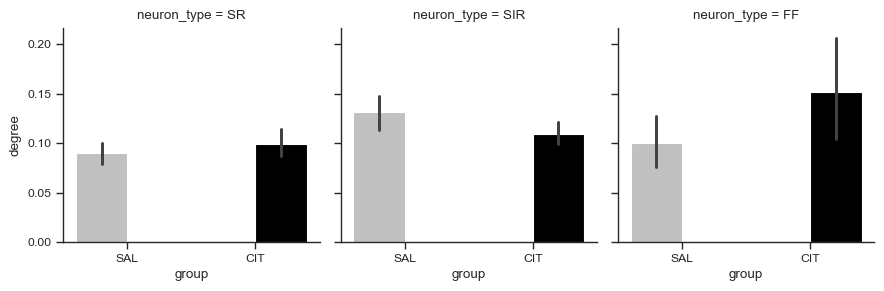

In [28]:
g = sns.FacetGrid(
    data=df_node,
    col="neuron_type",
    col_order=["SR", "SIR", "FF"]
)

g.map_dataframe(
    sns.barplot,
    x="group",
    hue="group",
    y="degree",
    dodge=True,
    hue_order=["SAL", "CIT"],   
    palette=PAL_GREY_BLACK[::-1],
    estimator=np.mean,
)

### Edge models

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone
from sklearn.pipeline import make_pipeline


def get_Xy(df, y_col, x_cols=["distance", "nt_comb"], shuffle=False):
    X = df[x_cols]
    y = df[y_col].values
    if shuffle:
        y = np.random.permutation(y)
    return X, y

def run_edge_mod(df, clf, y_col, scoring, x_cols=["distance", "nt_comb"], n_boot=1000):
    X_str, y = get_Xy(df.copy(), y_col=y_col, x_cols=x_cols, shuffle=False)
    y = LabelEncoder().fit_transform(y)
    ct = ColumnTransformer(
        [("ohe", OneHotEncoder(sparse=False), ["nt_comb"])],
        remainder="passthrough",
    )
    X = ct.fit_transform(X_str)
    clf_obs = clone(clf)

    scores_obs = cross_val_score(
        clf_obs, 
        X, 
        y, 
        cv=KFold(shuffle=True), 
        scoring=scoring,
        ).mean()

    scores_boot = []
    for i in range(n_boot):
        X_str, y = get_Xy(df.copy(), y_col="same_ensemble", shuffle=True)
        ct = ColumnTransformer(
            [("ohe", OneHotEncoder(sparse=False), ["nt_comb"])],
            remainder="passthrough",
        )
        y = LabelEncoder().fit_transform(y)
        X = ct.fit_transform(X_str)
        clf_boot = clone(clf)
        score = cross_val_score(
            clf_boot, 
            X, 
            y, 
            cv=KFold(shuffle=True), 
            scoring=scoring,).mean()
        scores_boot.append(score)
    scores_boot = np.array(scores_boot)
    return scores_obs, scores_boot


# ensemble_sal_obs, ensemble_sal_boot = run_edge_mod(
#     df=df_edge.query("group == 'SAL'"), 
#     clf = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=10)),
#     y_col="same_ensemble", 
#     x_cols=["distance", "nt_comb"],
#     n_boot=100,
#     )

# ensemble_cit_obs, ensemble_cit_boot = run_edge_mod(
#     df=df_edge.query("group == 'CIT'"), 
#     clf = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=10)),
#     y_col="same_ensemble", 
#     x_cols=["distance", "nt_comb"],
#     n_boot=100,
#     )


weight_sal_obs, weight_sal_boot = run_edge_mod(
    df=df_edge.query("group == 'SAL'"), 
    clf = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=10)),
    y_col="weight", 
    scoring="r2",
    x_cols=["distance", "nt_comb"],
    n_boot=100,
    )

weight_cit_obs, weight_cit_boot = run_edge_mod(
    df=df_edge.query("group == 'CIT'"), 
    clf = make_pipeline(StandardScaler(), DecisionTreeRegressor(max_depth=10)),
    y_col="weight", 
    scoring="r2",
    x_cols=["distance", "nt_comb"],
    n_boot=100,
    )

In [50]:
weight_sal_obs

-0.03861551719666525

In [51]:
weight_cit_obs

-0.006034194153805838